<a id="inicio"></a>
<br><br><br>
<h2><font color="#B51700" size=5>MNIST (Digit Recognizer)</font></h2>



<h1><font size=5>Visión por computador: CNN y transfer learning con Keras</font></h1>


---

***Importante:*** no se garantiza la reproducibilidad exacta de la libreta debido al uso de la GPU. Aunque se deben de obtener resultados similares.

# 1. Introducción

En este notebook se trabajará con el problema de visión por computador `MNIST`. Este conjunto de datos contiene imágenes de dígitos escritos a mano y el objetivo es entrenar un modelo que sea capaz de identificar que dígito hay en cada imagen. Los datos han sido extraídos de la competición de `kaggle` [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer).

`MNIST` (Modified National Institute of Standards and Technology) es el conjunto de datos perfecto para introducirnos en el mundo de la visión por computador. Se podría decir que es el "hello world" de los conjuntos de datos de este tipo de problemas.

El objetivo principal de este notebook es ser bastante completo y que pueda ser usado como guía o tutorial para trabajar con este tipo de problemas. No es un objetivo obtener un score demasiado alto aunque aun así se han obtenido buenos resultados.

A lo largo de este notebook se utilizará la librería `Keras` para crear las redes neuronales que se utilizarán para resolver el problema.

Primero se realizará la carga de los datos y se visualizarán algunas imágenes. Después se aplicará la técnica `aumento de datos` para crear más imágenes de entrenamiento que nos permitan obtener mejores resultados. Llegados a este punto se definirán y entrenarán las redes neuronales que utilizaremos para resolver el problema. Utilizando la librería `Keras` se definirá una red neuronal convolucional y una segunda red aplicando `transfer learning` con el modelo `VGG16`. Después de entrenar a estos dos modelos se definirá una tercera red neuronal que resultará de la unión de estos dos modelos (`ensemble`). Finalmente se guardarán los modelos entrenados y se realizará la predicción sobre el conjunto de test.

Empezaremos importando las librerías necesarias.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications import VGG16, VGG19
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.layers import GaussianNoise, Average, BatchNormalization, Lambda, Resizing
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

Para trabajar con redes neuronales de una forma más eficiente, vamos a comprobar si tenemos activa la GPU para reducir el tiempo de ejecución de la libreta.

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    raise RuntimeError('No GPU devices are used in the host')

Antes de cargar los datos y empezar a trabajar en el problema se va a establecer una semilla para que los resultados obtenidos a lo largo de la libreta puedan ser reproducibles. Aunque al estar utilizando Keras con la GPU activada no se pueden reproducir los experimentos, aún así vamos a usar la semilla ya que es una buena práctica.

In [3]:
seed = 42

# 2. Carga de datos

Se van a cargar los datos que se van a usar para entrenar y validar los modelos.

In [4]:
path_data = './data/'
train_df = pd.read_csv(path_data + 'train.csv')

Visualizamos 5 muestras de ejemplo. Podemos ver que cada muestra tiene 785 valores.

La columna `label` es la variable clase que indica el dígito que hay en esa imagen. El resto de las 784 columnas restantes son los píxeles de la imagen.

In [5]:
train_df.sample(5, random_state=seed)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5457,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38509,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25536,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31803,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39863,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora se va comprobar si tenemos algún valor `null` y la forma de los datos.

In [6]:
print('Shape: ' + str(train_df.shape))
print('Cantidad de valores null: ' + str(train_df.isnull().sum().sum()))

Shape: (42000, 785)
Cantidad de valores null: 0


Vamos a comprobar si tenemos un dataset balanceado o no mediante un gráfico.

<AxesSubplot:xlabel='label', ylabel='count'>

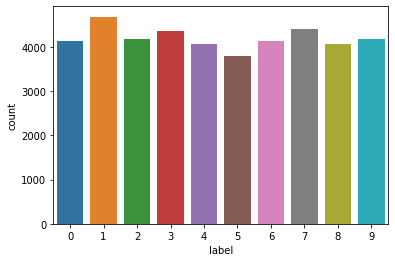

In [7]:
sns.countplot(data = train_df, x = 'label')

Aquí podemos ver que tenemos un `dataset balanceado` en el que tenemos más o menos una cantidad similar de valores para cada posible valor de la variable clase.

A partir del dataframe de pandas vamos a extraer la variable `y` (columna label) y la variable `X` (columnas píxel). Como vimos anteriormente para la variable `X` tenemos 784 valores. Vamos a estructurarlos en una matriz de 28x28.

Así, para cada imagen tendremos una matriz de píxeles de 28x28.

In [8]:
y_train_full = train_df["label"].values
X_train_full = train_df.drop("label", axis=1).values.reshape(-1, 28, 28, 1)

X_train_full.shape

(42000, 28, 28, 1)

Vamos a convertir también la variable clase en una variable categórica. En este caso tendremos 10 categorías, una por cada número del 0 al 9.

In [9]:
y_train_full = to_categorical(y_train_full, num_classes = 10)
y_train_full.shape

(42000, 10)

Visualizamos al azar 10 muestras del conjunto de datos.

<Figure size 1152x864 with 0 Axes>

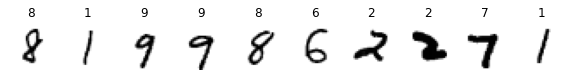

In [10]:
plt.figure(figsize=(16, 12), tight_layout=True, facecolor="white")

np.random.seed(seed)
random_index = np.random.choice(len(X_train_full), size=10, replace=False)

fig, axis = plt.subplots(1, 10, figsize=(10,10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train_full[random_index[i]], cmap='binary')
    ax.set(title = y_train_full[random_index[i]].argmax())
    ax.axis("off")
    
plt.show()

Para acabar con la carga de datos se va a divir el conjunto de datos de entrenamiento en dos:

- Conjunto de datos de entrenamiento: datos que se usarán para seleccionar la mejor configuración de parámetros para los modelos y entrenarlos con esa configuración.
- Conjunto de datos de validación: datos que se usarán después de entrenar los modelos con la mejor configuración de parámetros para evaluar su rendimiento.

***Importante:*** aunque se tiene un conjunto de datos balanceado se va a realizar una partición de datos estratificada para mantener el mismo porcentaje de valores de la variable clase.


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=seed
)

Visualizamos el formato de los datos para ambos conjuntos.

In [12]:
print('Datos de entrenamiento: ' + str(X_train.shape) + str(y_train.shape))
print('Datos de validación: ' + str(X_val.shape) + str(y_val.shape))

Datos de entrenamiento: (33600, 28, 28, 1)(33600, 10)
Datos de validación: (8400, 28, 28, 1)(8400, 10)


Vemos que tenemos 33600 muestras para el entrenamiento y 8400 para la validación.
- Cada muestra de la variable X es una matriz (imagen) de 28x28x1.
- Para la variable y tenemos una variable categórica con 10 valores.

# 3. Aumento de datos

Ahora se va a aplicar la técnica aumento de datos. Esta técnica, también conocida como `data augmentation`, se refiere a la manipulación de los datos de entrada para crear nuevos datos que son similares a los originales pero tienen alguna variación. Esta técnica es ampliamente utilizada en el aprendizaje automático y en la visión por computador.

Las ventajas de utilizar esta técnica es que permite:
- Aumentar la cantidad de datos de entrenamiento disponibles para el modelo.
- Mejorar la generalización.
- Prevenir el sobreajuste.

Keras nos permite aplicar esta técnica de una forma muy sencilla utilizando el objeto `ImageDataGenerator`. En este caso se generarán dos generadores, uno para los datos de entrenamiento y validación y otro para los datos de prueba.

El aumento de datos que vamos a aplicar es:
* `rescale`: sirve para normalizar la imagen. Como los píxeles de la imagen original tienen un valor dentro del rango [0,255] y la red neuronal admite como entrada valores entre el 0 y 1, tenemos que normalizar los valores. Esto hay que realizarlo sobre las imágenes de test y de validación también.
* `zoom_range`: aplica zoom de forma aleatoria a la imagen original. En este caso vamos a añadir un 10% máximo de zoom.
* `width_shift_range`: aplica de forma aleatoria un desplazamiento en las imagenes de forma horizontal. Un máximo del 10%.
* `height_shift_range`: aplica de forma aleatoria un desplazamiento en las imagenes de forma vertical. Un máximo del 10%
* `rotation_range`: aplica de forma aleatoria rotación sobre la imagen original. Un máximo de 10 grados.

***Nota1:*** No añadiremos la rotación de las imagenes, ya que con una rotación vertical se puede confundir un 6 con un 9 o viceversa.

***Nota2:*** Solo le vamos a aplicar aumento de datos al conjunto de entrenamiento. En el generador para los datos de prueba solo se aplicará un reescalado a los datos de entrada, ya que no conviene modificar los datos de prueba y validación.

In [13]:
rescale = 1 / 255

train_generator = ImageDataGenerator(rescale=rescale,
                                     zoom_range = 0.1,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     rotation_range = 10)

test_generator = ImageDataGenerator(rescale=rescale)

Ahora hay que construir los iteradores a partir de los generadores de imágenes que se han definido. 

Los `iteradores` nos permiten iterar sobre los datos y generar un batch de datos aumentados, aplicando las transformaciones indicadas en el generador.

In [14]:
batch_size = 64

train_iterator = train_generator.flow(X_train, y_train, batch_size=batch_size, seed=seed)
val_iterator = test_generator.flow(X_val, y_val, batch_size=batch_size, seed=seed)

# 4. Modelos basados en redes neuronales

Aquí se van a definir dos modelos basados en redes neuronales para resolver el problema de `MNIST`.

## 4.1. CNN

El primer modelo será una red neuronal convolucional (CNN).

Primero se guarda en una variable el formato de la entrada de los datos a la red neuronal. Como vimos anteriormente cada dato de entrada es una imagen de 28x28x1.

In [15]:
input_shape = (28,28,1)

La estructura de la red neuronal convolucional contará con la siguiente secuencia de capas:

* Como primera capa utilizaremos una capa `GaussianNoise` para añadir ruido aleatorio gausiano para evitar el sobreajuste al conjunto de datos de entrenamiento y así que la red aprenda a tratar con datos ruidosos. Como la primera capa de la red necesita definir la forma de los datos de entrada, esta capa no puede ser la primera, por lo que hay que añadir una capa `Input` que nos permite definir la forma de los datos de entrada.

* Después aplicamos dos capas convolucionales, seguidas de dos capas convolucionales transpuestas. Las capas convolucionales transpuestas realizan la operación contraria a las capas convolucionales. Lo que estamos haciendo con estas cuatro capas es comprimir la información de la imagen (con las dos capas convolucionales) y descomprimirla (con las dos capas convolucionales transpuestas). Hacemos esto con el objetivo de quitar el ruido a la imagen original y así hacer que la red aprenda a reconstruir la imagen.

* Capa convolucional + *ReLu* + Capa convolucional + *ReLU* + *pooling* + Dropout (para reducir el sobreajuste).

* Capa convolucional + *ReLu* + Capa convolucional + *ReLU* + *pooling* + Dropout.

* Capa complementamente conectada + Dropout.

In [16]:
cnn_model=Sequential()

cnn_model.add(Input(shape=input_shape))
cnn_model.add(GaussianNoise(0.17))
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
cnn_model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu'))
cnn_model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn_model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu'))
cnn_model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))
    
cnn_model.add(Flatten())
cnn_model.add(Dense(64,activation='relu')) 
cnn_model.add(Dropout(0.20))
    
cnn_model.add(Dense(10,activation='softmax'))

Vemos la estructura de la red que hemos definido, junto con la cantidad de parámetros que tiene que aprender.

In [17]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 28, 28, 1)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 26, 26, 32)       18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       18496     
 ranspose)                                                       
                                                        

Obtenemos que el modelo tiene que entrenar 223,914 parámetros. Aunque parezcan muchos, este es un modelo muy pequeño debido a que para problemas más complejos se suelen crear redes neuronales con millones de parámetros, pero para un problema tan sencillo como `MNIST` no es necesario.

Finalmente compilamos el modelo. Tras esto, el modelo ya esta listo para ser entrenado.

In [18]:
cnn_model.compile(loss="categorical_crossentropy",
              metrics="accuracy",
              optimizer="adam")

## 4.2. Transfer learning

El segundo modelo será una red neuronal convolucional que utilizará la técnica de `transfer learning`. Esta técnica consiste en utilizar un modelo pre-entrenado en una tarea similar al problema que se está tratando, y utilizarlo como punto de partida para solucionar el problema, en lugar de entrenar un modelo desde 0.

Por ejemplo, se puede utilizar un modelo que ha sido entrenado para reconocer imágenes y aplicar el conocimiento que ha aprendido como punto de partida para resolver un problema de clasificación de imágenes. Así, se suelen utilizar estas redes pre-entrenadas para extraer características de las imágenes de entrada.

En este caso se utilizará el modelo `VGG16`, que fue entrenado para la competición de clasificación de imágenes `ImageNet`.

Para empezar vamos a descargar el modelo desde `Keras`, indicando que recibirá una entrada de tamaño 75x75 en formato RGB. Además, hay que indicarle que utilice los pesos que se entrenaron con el conjunto de datos `ImageNet`.

Por último es muy importante indicar que no queremos que incluya la última capa de la red (`include_top=False`), ya que esa capa es la que se encarga de realizar la clasificación final, y nosotros lo que queremos es extraer características de la imagen de entrada. 

In [19]:
new_size = 75
weights = "imagenet"
include_top = False

vgg16 = VGG16(weights=weights, include_top=include_top, input_shape=(new_size,new_size,3))

Ahora hay que marcar las capas de este modelo como no entrenables. Solo nos interesa que extraígan características a partir de la imagen de entrada. Esto reduce considerablemente la cantidad de parámetros que tendrá que entrenar la red.

In [20]:
for layer in vgg16.layers:
    layer.trainable = False

Como el modelo pre-entrenado `VGG16` necesita de entrada imágenes RGB, necesitamos convertir nuestras imágenes de entrada a este formato, por lo que vamos a definir una función que asignaremos a una capa para que haga este proceso.

In [21]:
def gray_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

La estructura de la red neuronal convolucional contará con la siguiente secuencia de capas:

* Capa `Input` que nos permite definir la forma de los datos de entrada.

* Capa `Resizing` que aumente el tamaño de los datos de entrada a 75x75.

* Capa `Lambda` que convierta los datos de entrada a formato RGB.

* Modelo `VGG16` que nos permita extraer características.

* Capa complementamente conectada + Dropout.

In [22]:
tl_model=Sequential()
tl_model.add(Input(shape=input_shape))
tl_model.add(Resizing(new_size, new_size))
tl_model.add(Lambda(gray_to_rgb))
tl_model.add(Resizing(new_size, new_size))

tl_model.add(vgg16)
    
tl_model.add(Flatten())
tl_model.add(Dense(128,activation="relu")) 
tl_model.add(Dropout(0.2))
    
tl_model.add(Dense(10,activation="softmax"))

Vemos la estructura de la red que hemos definido, junto con la cantidad de parámetros que tiene que aprender.

In [23]:
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 75, 75, 1)         0         
                                                                 
 lambda (Lambda)             (None, 75, 75, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 75, 75, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)              

Obtenemos que el modelo tiene que entrenar 263,562 parámetros. Podemos observar que esta es una pequeña cantidad de parámetros del total que tiene la red (casi 15 millones). Esto es gracias a que todas las capas del modelo `VGG16` no hay que entrenarla, pero si que nos proporciona un conocimiento útil para resolver este problema.

Finalmente compilamos el modelo. Tras esto, el modelo ya esta listo para ser entrenado.

In [24]:
tl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 5. Entrenamiento y validación de los modelos

Ahora que se han definido los modelos podemos entrenarlos. Primero definiremos la cantidad de épocas que utilizaremos para entrenar cada modelo y el `learning rate`.

In [25]:
epochs = 100
lr = 1e-3

Para el entrenamiento vamos a utilizar dos `callbacks` de los que nos proporciona `keras`:

* `EarlyStopping`: permite monitorizar el entrenamiento y, si no se produce mejora entre las distintas épocas, se para el entrenamiento para reducir el tiempo del entrenamiento en caso de que no se obtengan mejoras. En este caso se ha indicado que se pare el entrenamiento si no se ha mejorado en 5 épocas. Se le indica que el valor que tiene que monitorizar para para ver si se mejora es `loss` en los datos de validación (`val_loss`). Es muy importante también indicar que si se para el entrenamiento porque no se mejoran los resultados, restaure los pesos que se tenían en la mejor época.

* `LearningRateScheduler`: permite modificar el ratio de aprendizaje durante el entrenamiento del modelo. Al iniciar un epoch, se actualiza el ratio de aprendizaje con el epoch y tasa de aprendizaje actual y se lo aplica al optimizador para actualizarlo.

***Nota:*** el entrenamiento no debería de durar las 100 épocas que hemos indicado anteriormente porque gracias al `EarlyStopping` parará antes cuando el modelo deje de mejorar los resultados de los datos de validación.

In [26]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
lrs = LearningRateScheduler(lambda x: lr * 0.95 ** x)

Se realiza el entrenamiento de la red neuronal convolucional definida.

In [27]:
convolutional_history = cnn_model.fit(train_iterator,
                                      epochs=epochs,
                                      callbacks = [early_stopping,lrs],
                                      validation_data=val_iterator)

Epoch 1/100
525/525 [==============================] - 18s 28ms/step - loss: 0.5056 - accuracy: 0.8400 - val_loss: 0.1015 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 14s 27ms/step - loss: 0.1619 - accuracy: 0.9520 - val_loss: 0.0470 - val_accuracy: 0.9858 - lr: 9.5000e-04
Epoch 3/100
525/525 [==============================] - 14s 27ms/step - loss: 0.1198 - accuracy: 0.9645 - val_loss: 0.0401 - val_accuracy: 0.9875 - lr: 9.0250e-04
Epoch 4/100
525/525 [==============================] - 14s 27ms/step - loss: 0.1045 - accuracy: 0.9685 - val_loss: 0.0399 - val_accuracy: 0.9885 - lr: 8.5737e-04
Epoch 5/100
525/525 [==============================] - 14s 27ms/step - loss: 0.0947 - accuracy: 0.9717 - val_loss: 0.0395 - val_accuracy: 0.9889 - lr: 8.1451e-04
Epoch 6/100
525/525 [==============================] - 14s 27ms/step - loss: 0.0810 - accuracy: 0.9756 - val_loss: 0.0316 - val_accuracy: 0.9905 - lr: 7.7378e-04
Epoch 7/100
525/525 [===========

Se realiza el entrenamiento del modelo que utiliza transfer learning.

In [28]:
tl_history = tl_model.fit(train_iterator,
                          epochs=epochs,
                          callbacks = [early_stopping,lrs],
                          validation_data=val_iterator)

Epoch 1/100
525/525 [==============================] - 57s 105ms/step - loss: 0.3343 - accuracy: 0.9038 - val_loss: 0.1051 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 54s 104ms/step - loss: 0.1352 - accuracy: 0.9590 - val_loss: 0.0853 - val_accuracy: 0.9745 - lr: 9.5000e-04
Epoch 3/100
525/525 [==============================] - 54s 103ms/step - loss: 0.1036 - accuracy: 0.9685 - val_loss: 0.0726 - val_accuracy: 0.9779 - lr: 9.0250e-04
Epoch 4/100
525/525 [==============================] - 54s 103ms/step - loss: 0.0956 - accuracy: 0.9709 - val_loss: 0.0741 - val_accuracy: 0.9780 - lr: 8.5737e-04
Epoch 5/100
525/525 [==============================] - 54s 104ms/step - loss: 0.0851 - accuracy: 0.9731 - val_loss: 0.0572 - val_accuracy: 0.9814 - lr: 8.1451e-04
Epoch 6/100
525/525 [==============================] - 55s 104ms/step - loss: 0.0764 - accuracy: 0.9760 - val_loss: 0.0589 - val_accuracy: 0.9807 - lr: 7.7378e-04
Epoch 7/100
525/525 [=====

Para poder visualizar de forma gráfica la evolución del entrenamiento a lo largo de las épocas, se ha definido una función que recibe como parámetro el historial devuelto por el entrenamiento (en `keras` lo devuelve el método `fit`).

In [29]:
def plot_history(history):
    
    train_loss = history.history["loss"]
    train_accuracy = history.history["accuracy"]
    validation_loss = history.history["val_loss"]
    validation_accuracy = history.history["val_accuracy"]

    (fig, ax) = plt.subplots(1, 2)

    fig_size = (10, 3)
    fig.set_size_inches(fig_size)

    ax[0].set_title("Model loss")
    ax[1].set_title("Model accuracy")

    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")

    ax[0].plot(train_loss)
    ax[0].plot(validation_loss)
    ax[1].plot(train_accuracy)
    ax[1].plot(validation_accuracy)

    legend = ["Train", "Validation"]
    ax[0].legend(legend, loc="upper right")
    ax[1].legend(legend, loc="upper right")

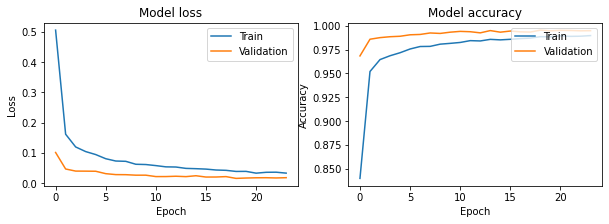

In [30]:
plot_history(convolutional_history)

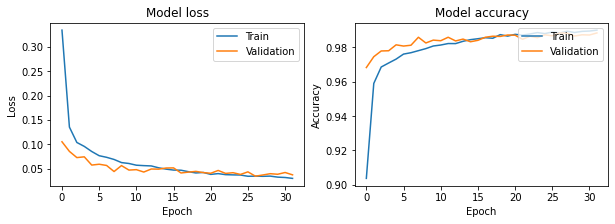

In [31]:
plot_history(tl_history)

De los dos gráficos anteriores se puede observar que ambos modelos obtienen muy buenos resultados (casi el 100% de `accuracy`). Además, no cuentan con sobreajuste ya que el `accuracy` para los datos de entrenamiento y de validación es muy similar. Hay que recordar que se está trabajando con un problema muy sencillo de visión por computador, por lo que es fácil obtener tan buenos resultados.

De los dos modelos entrenados, el primer modelo tarda menos tiempo en ser entrenado debido a que es un modelo más pequeño y con menos parámetros. También es el que mejores resultados obtiene. Esto es debido a que se han entrenado todas las capas de ese modelo, permitiendo adaptarse a la resolución de este problema, mientras que en la segunda red solo se ha entrenado la capa completamente conectada.

Por lo general un modelo entrenado desde 0 funcionará mejor que un modelo que aplique `transfer learning`. Aunque en problemas muy grandes y complejos diseñar un modelo completo puede conllevar un gran coste computacional y de tiempo (días, semanas...), por lo que es buena idea aplicar `transfer learning` para reducir este coste si es capaz de obtener buenos resultados igualmente.

# 6. Ensemble

Ahora se va a intentar mejorar el `accuracy` construyendo un ensemble formado por la unión de los dos modelos que tenemos ya entrenados. La idea es generar un nuevo modelo que utilice a los dos modelos anteriores para obtener dos predicciones y realice la media de sus predicciones.

***Nota***: no es necesario entrenar este modelo porque utiliza a dos modelos ya entrenados para realizar las predicciones.

In [32]:
models = [cnn_model, tl_model]
model_input = Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)

Vemos la estructura del ensemble que hemos definido.

In [33]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           224554      ['input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           14978250    ['input_4[0][0]']                
                                                                                                  
 average (Average)              (None, 10)           0           ['sequential[0][0]',             
                                                                  'sequential_1[0][0]']       

Vemos que la cantidad de parámetros que tiene es la suma de los dos modelos anteriores. Una opción sería reentrenar este modelo para que estos parámetros se adaptasen a la nueva estructura, aunque al utilizar dos modelos ya entrenados no es obligatorio y nos podemos ahorra el tiempo del nuevo entrenamiento ya que se pueden obtener muy buenos resultados sin reentrenar, y quizá, al reentrenarlo, no logremos mejorar los resultados.

Se compila el ensemble.

In [34]:
ensemble_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Se va a evaluar el ensemble utilizando los datos de validación. Además, se va a comparar con los dos modelos anteriores.

In [35]:
print('CNN: ' + str(cnn_model.evaluate(val_iterator, verbose=0)))
print('VGG16: ' + str(tl_model.evaluate(val_iterator, verbose=0)))
print('Ensemble: ' + str(ensemble_model.evaluate(val_iterator, verbose=0)))

CNN: [0.01598714478313923, 0.9953571557998657]
VGG16: [0.03442300483584404, 0.9883333444595337]
Ensemble: [0.019472824409604073, 0.9957143068313599]


Se obtiene que el ensemble obtiene unos resultados un poco (muy poco) mejores al modelo CNN. Si se hubiera obtenido un segundo modelo un poco mejor, el ensemble también obtendría mejores resultados.

# 7. Guardar los modelos

Es una buena práctica guardar los modelos ya entrenados para poder volver a utilizarlos en otras sesiones.

In [36]:
path_models = 'models/'
cnn_path = path_models + 'cnn.h5'
tl_path = path_models + 'tl.h5'
ensemble_path = path_models + 'ensemble.h5'

In [37]:
cnn_model.save(cnn_path)
tl_model.save(tl_path)
ensemble_model.save(ensemble_path)

Se pueden volver a cargar los modelos con la siguiente instrucción.

In [38]:
loaded_model = load_model(ensemble_path)

# 8. Predicción conjunto de test

Para acabar con esta libreta se va a utilizar el ensemble (que es el que mejores resultados obtiene) para predecir el conjunto de test.

Para ello primero se leerá el archivo.

In [39]:
test_df = pd.read_csv(path_data + 'test.csv')

test_df.sample(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
11119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora se va comprobar si tenemos algún valor `null` y la forma de los datos.

In [40]:
print(('Shape: ' + str(test_df.shape)))
print('Cantidad de valores null: ' + str(test_df.isnull().sum().sum()))

Shape: (28000, 784)
Cantidad de valores null: 0


Con esto comprobamos que, efectivamente, los datos de prueba tienen la misma estructura que los datos de entrenamiento.

Así que vamos a estructurarlos en una matriz de 28x28 al igual que se hizo anteriormente con los datos de entrenamiento.

In [41]:
X_test = test_df.values.reshape(-1, 28, 28, 1)

Utilizando el `test_generator` que se definió anteriormente para los datos de validación se va a construir un nuevo iterador para los datos de test. Al igual que para los datos de validación la única transformación que se hará sobre estos datos será la de normalizar los datos para que estén en la escala correcta.

***Nota:*** al crear un iterador para los datos de test es muy importante marcar la opción de `shuffle` a `False` para que en la predicción no se desordenen las predicciones, y así sepamos a que dato de entrada corresponde cada predicción.

In [42]:
test_iterator = test_generator.flow(X_test, batch_size=batch_size, seed=seed, shuffle=False)

Ahora ya se pueden predecir los datos de prueba.

In [43]:
y_pred = loaded_model.predict(test_iterator)
y_pred_classes = np.argmax(y_pred, axis = 1)

438/438 [==============================] - 39s 89ms/step


Vamos a visualizar algunas predicciones junto con la imagen correspondiente.

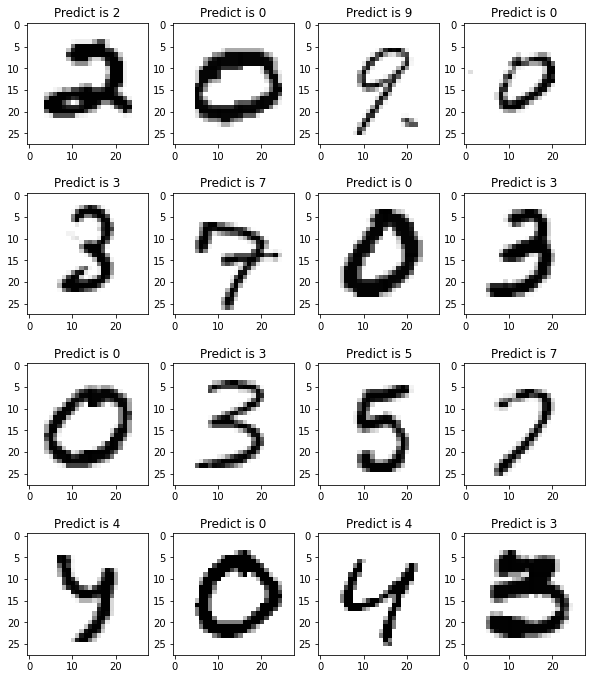

In [44]:
fig, axis = plt.subplots(4, 4, figsize=(10, 12))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test[i], cmap='binary')
    ax.set(title = "Predict is " + str(y_pred_classes[i]))

Finalmente, se crea un `.csv` que almacene el id de la imagen junto con la predicción obtenida.

In [45]:
results = pd.Series(y_pred_classes,name="Label")

submissions=pd.DataFrame({"ImageId": list(range(1,len(results)+1)),
                         "Label": results})

submissions.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [46]:
submissions.to_csv(path_data+'submission.csv', index=False, header=True)